# Final Project

In [157]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import roc_curve, roc_auc_score

In [3]:
# Loading the whole data set
#Original_dataset = pd.read_csv('yelp_review.csv')

In [4]:
#Original_dataset.shape

(5261668, 9)

In [7]:
data_set = pd.read_csv('data_sample.csv')

In [8]:
data_set.sample(n = 5)

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
139,dH2ygH2veoWYqQbWz20Cbg,9VxXoiBXnx7ANNFMi51miA,uC3qwaxsOkdJzpOc0v1Mog,5,2017-01-29,Cafe Hollander is great! Great atmosphere and ...,0,0,0
640,8MZ251bLKS2RHtJl4XN-RA,LH-28rAe1jPzjRDq4Di6Ug,I6__xsL6K_aGeEJbN4sMJg,5,2016-06-15,From Cali seeing some negative reviews the onl...,0,0,0
800,qJ47IBkZOrSAvJtty6TyzA,OvUNa2sFcgCN_oRHtPqV7Q,yLp3w1r0DMcw_pAg5NTfFw,5,2015-04-02,It was quick and effective. Good system in pl...,2,0,0
448,75rtF88Xt4fiV3DmTdWZhw,eALqm4FVWYjXe-04EED3PQ,_ZwDLtBopUHb6F2mIPFUJg,5,2016-07-27,How can Oregano's be receiving an average of f...,0,0,0
654,quAXmCjgCYGUfGoXhDhETQ,Kj9cFO70zZOQorN0mgeLWA,w9TXFk3zKcVQJ92Ow992mg,4,2015-06-26,Cake cake cake cake cake....now that I've put ...,3,2,2


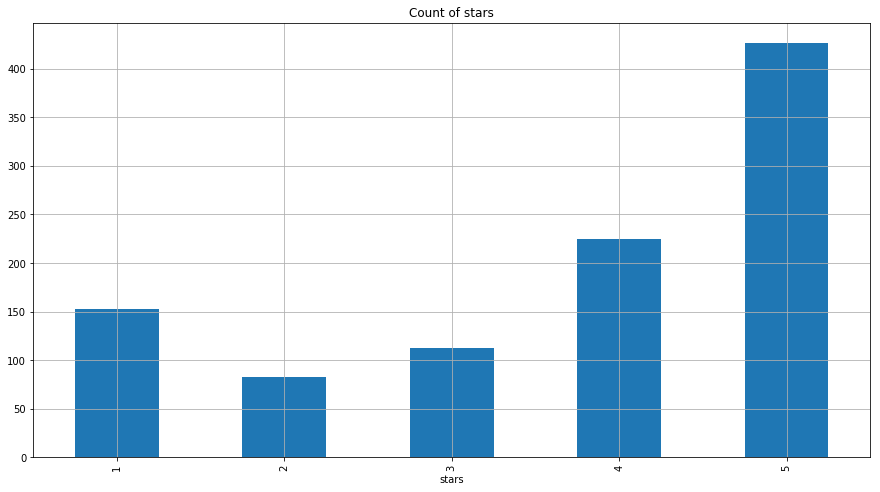

In [9]:
data_set.groupby('stars').stars.count().plot(kind='bar',legend=False, figsize=(15,8),grid=True, title= 'Count of stars')

In [10]:
# Mapping stars column to 0 and 1
df = data_set[['stars','text']]
df['stars'] = df['stars'].map({ 1:0, 2:0, 3:0, 4:1, 5:1})

C:\Users\Babak\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [12]:
#Sampling 1000 records
sample = df.sample(n=1000)

# Tokenizing and Assigning weight to the terms (TF-IDF Matrix)

In [14]:
# Tokenizing and getting rid of stopping words
def get_tokens(sentence):
#sent = "this is a foo bar, bar black sheep."
    stop = stopwords.words('english') + list(string.punctuation)
    return [i for i in word_tokenize(sentence.lower()) if i not in stop]

In [15]:
"""
    Given a text corpus Returns a new Normalized Term Frequency Matrix 
"""
def buildTF(corpus):
    for index,row in corpus.iterrows():
        tokens = get_tokens(corpus.text[index])
        for token in tokens:
            corpus.at[index, token] = tokens.count(token)

In [16]:
def normalizer(x, maximum):
    return (0.5+(0.5*x)/maximum)

In [17]:
def doubleNormalize(TF):
    for column in TF.columns.values:
        maximum = max(TF[column])
        TF[column]=TF[column].apply(normalizer, args=(maximum,))

In [18]:
#TF = buildTF(sample)
X = sample[['text']]
y = sample[['stars']]
buildTF(X)
X = X.drop(['text'], axis = 1)
X = X.fillna(0)
doubleNormalize(X)
X.sample(n=5)
#print(label)

,horrible,customer,service,basically,ignored,10,minutes,looked,around,'s,...,seller,intentionally,waaaaaay,primanti,sever,overflow,pgh,heel,sahara,exploded
759,0.5,0.500,0.500,0.5,0.5,0.5,0.5,0.5,0.5,0.500000,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
167,0.5,0.500,0.625,0.5,0.5,0.5,0.5,0.5,0.5,0.500000,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
187,0.5,0.500,0.500,0.5,0.5,0.5,0.5,0.5,0.5,0.500000,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
521,0.5,0.500,0.500,0.5,0.5,0.5,0.5,0.5,0.5,0.555556,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
656,0.5,0.625,0.625,0.5,0.5,0.5,0.5,0.5,0.5,0.500000,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


In [19]:
""" Given a TF Matrix changes it to Inverse Document Frequency (IDF) Matrix """
def multiply(x,y):
    return x*y
def build_TF_IDF(TF):
    for column in TF:
        IDF = np.log10(len(TF[column])/len(TF[TF[column]>0.5]))
        TF[column]=TF[column].apply(multiply, args=(IDF,))

In [20]:
build_TF_IDF(X)

In [22]:
X.sample(n=5)

,horrible,customer,service,basically,ignored,10,minutes,looked,around,'s,...,seller,intentionally,waaaaaay,primanti,sever,overflow,pgh,heel,sahara,exploded
492,0.792513,0.565384,0.263622,0.943028,1.349485,0.673394,0.603804,0.715899,0.706987,0.236830,...,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5
940,0.792513,0.565384,0.263622,0.943028,1.349485,0.673394,0.603804,0.715899,0.530240,0.263145,...,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5
761,0.792513,0.565384,0.395433,0.943028,1.349485,1.346787,0.603804,0.715899,0.530240,0.342088,...,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5
517,1.188770,0.565384,0.395433,0.943028,1.349485,0.673394,0.603804,0.715899,0.706987,0.289459,...,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5
691,0.792513,0.565384,0.263622,0.943028,1.349485,0.673394,0.603804,0.715899,0.530240,0.263145,...,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5


# Dimentiality reduction by running PCA

In [23]:
pca = PCA(n_components=100)
pca.fit(X)
TF_pca = pd.DataFrame(pca.transform(X))
print("original shape:  ", X.shape)
print("transformed shape: ", TF_pca.shape)

original shape:   (1000, 9673)
transformed shape:  (1000, 100)


In [24]:
#eig = np.linalg.eigvals(TF_pca)

# Splitting Data into Training and Test set

In [25]:
# Splitting data into train data and test data
X_train, X_test, y_train, y_test = train_test_split(TF_pca, y, test_size=.2, random_state=0)

# Model Development
## Kernel SVM Model

In [139]:
# Create a SVC classifier using an RBF kernel
svm = SVC(kernel='rbf', random_state=0, gamma=0.1, C=160, probability=True)
# Train the classifier
model = svm.fit(X_train, y_train.values.ravel())
# Get the predictions
y_predicted = model.predict(X_test)
y_score_SVMk = model.predict_proba(X_test)[:,1]

In [140]:
get_metrics(y_predicted, y_test)

Recall 0.804347826087
Precision 0.847328244275
Error_rate 0.235
Accuracy 0.765
F1 Score 0.825278810409


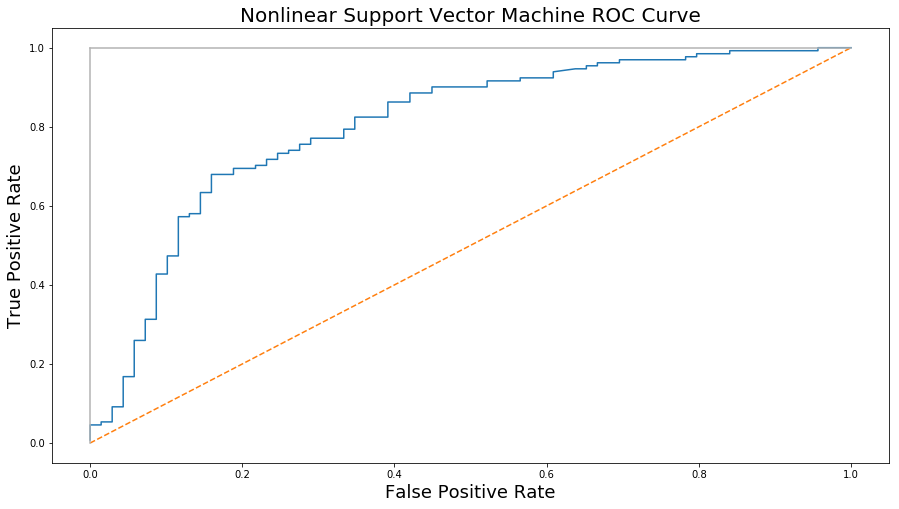

0.804513773648


In [149]:
# Create true and false positive rates
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score_SVMk)

# Plot ROC curve
plt.figure(figsize=(15,8))
plt.title('Nonlinear Support Vector Machine ROC Curve', fontsize=20)
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate', fontsize=18)
plt.xlabel('False Positive Rate', fontsize=18)
plt.show()
print('Area Under the Curve',roc_auc_score(y_test, y_score_SVMk))

## Training different SVM models with various Gamma values

In [58]:
# Training different svm kernel models with different gamma values
gamma = np.arange(0.005, 0.99, 0.05)
error_rate =[]
for g in gamma:
    # Create a SVC classifier using an RBF kernel
    svmk = SVC(kernel='rbf', random_state=0, gamma=g, C=80)
    # Train the classifier
    model = svmk.fit(X_train, y_train.values.ravel())
    # Get the predictions
    temp = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(temp,y_test).ravel()
    error_rate.append((fn+fp)/(tp+fn+fp+tn))

Text(0.5,1,'Error Rate with different Gamma Values')

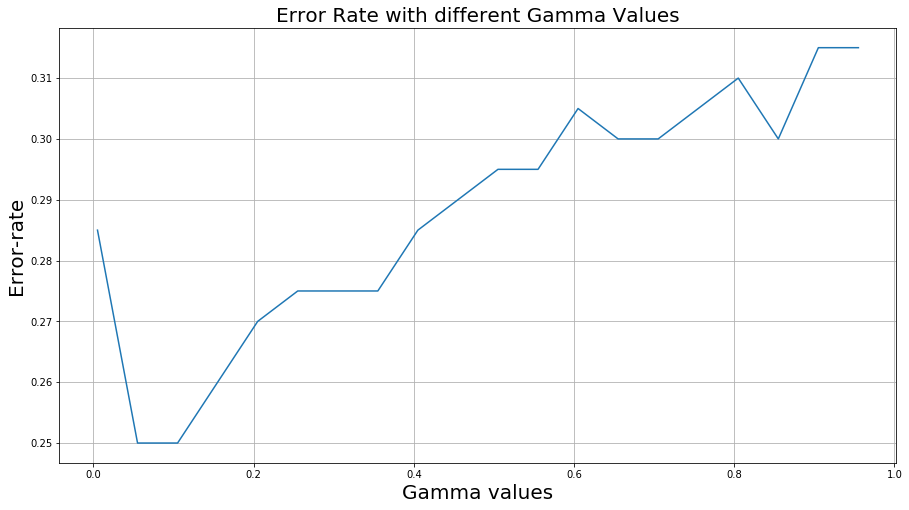

In [62]:
plt.subplots(figsize=(15,8))
plt.plot(gamma,error_rate)
plt.grid(zorder=0)
plt.ylabel('Error-rate', fontsize=20)
plt.xlabel('Gamma values', fontsize=20)
plt.title('Error Rate with different Gamma Values', fontsize = 20)

## Training different SVM models with various Cost values

In [135]:
# Training different svm kernel models with different C values
C = np.arange(100, 300, 5)
error_rate =[]
for c in C:
    # Create a SVC classifier using an RBF kernel
    svmk = SVC(kernel='rbf', random_state=0, gamma=0.1, C=c)
    # Train the classifier
    model = svmk.fit(X_train, y_train.values.ravel())
    # Get the predictions
    temp = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(temp,y_test).ravel()
    error_rate.append((fn+fp)/(tp+fn+fp+tn))

Text(0.5,1,'Error Rate using different C Values')

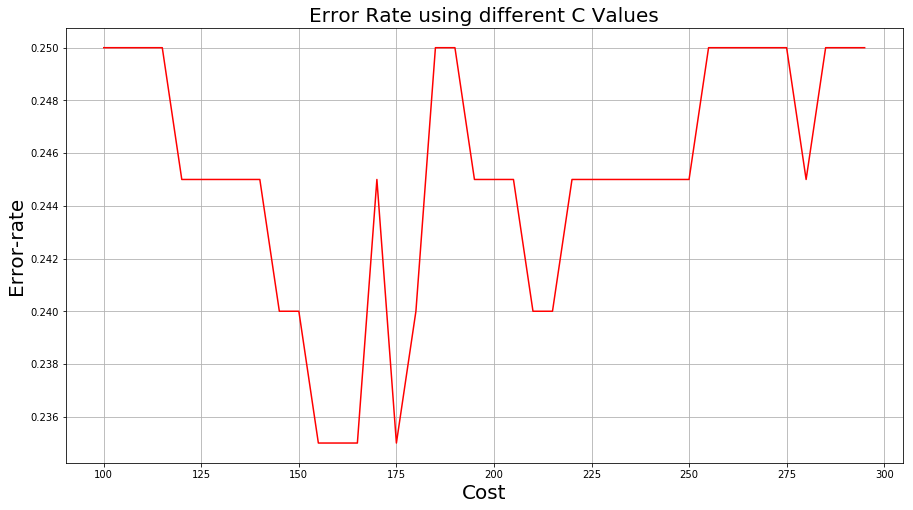

In [136]:
plt.subplots(figsize=(15,8))
plt.plot(C,error_rate,color = 'red')
plt.grid(zorder=0)
plt.ylabel('Error-rate', fontsize=20)
plt.xlabel('Cost', fontsize=20)
plt.title('Error Rate using different C Values', fontsize = 20)

In [79]:
#tp = conf[0][0]
#fn = conf[1][0]
#fp = conf[0][1]
#tn = conf[1][1]
def get_metrics(y_predicted,y_test):
    tn, fp, fn, tp = confusion_matrix(y_predicted,y_test).ravel()
    recal = tp/(tp+fn)
    precision = tp/(tp+fp)
    error_rate = (fn+fp)/(tp+fn+fp+tn)
    F1 = 2*((precision*recal)/(precision+recal))
    print('Recall', recal)
    print('Precision', precision)
    print('Error_rate', error_rate)
    print('Accuracy', 1-error_rate)
    print('F1 Score', F1)

## Linear SVM model

In [89]:
# Create a linear SVM classifier 
C = np.arange(0.1, 0.99, 0.1)
error_rate =[]
for c in C:
    linearSVM = LinearSVC(random_state=0, C = c)
    # Train the classifier
    model = linearSVM.fit(X_train, y_train.values.ravel())
    # Get the predictions
    temp = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(temp,y_test).ravel()
    error_rate.append((fn+fp)/(tp+fn+fp+tn))

Text(0.5,1,'Linear SVM Error Rate using different penalizing parameter')

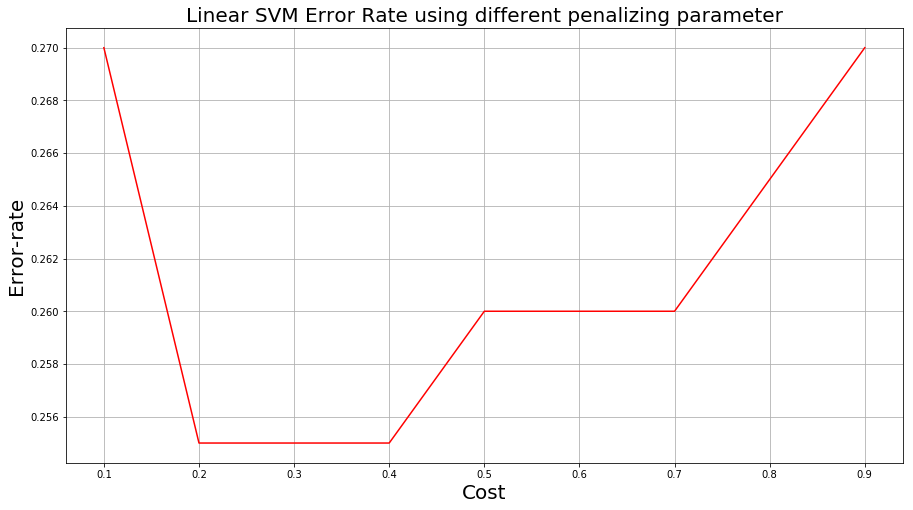

In [93]:
plt.subplots(figsize=(15,8))
plt.plot(C,error_rate,color = 'red')
plt.grid(zorder=0)
plt.ylabel('Error-rate', fontsize=20)
plt.xlabel('Cost', fontsize=20)
plt.title('Linear SVM Error Rate using different penalizing parameter', fontsize = 20)

In [151]:
linearSVM = LinearSVC(random_state=0, C = 0.3)
# Train the classifier
model = linearSVM.fit(X_train, y_train.values.ravel())
# Get the predictions
y_predicted = model.predict(X_test)

In [152]:
get_metrics(y_predicted, y_test)

Recall 0.75
Precision 0.916030534351
Error_rate 0.255
Accuracy 0.745
F1 Score 0.824742268041


## Bagged kernel approach

In [123]:
bagNum = 50
y_bagged = []
for i in range(bagNum):
    SX_train, SX_test, Sy_train, Sy_test = train_test_split(TF_pca, y, test_size=.1, train_size=.4, random_state= 42)
    # Create a SVC classifier using an RBF kernel
    DT_classifier = DecisionTreeClassifier(criterion='gini', min_samples_leaf=10, random_state=0, max_depth=5)
    # Train the classifier
    model = DT_classifier.fit(SX_train, Sy_train.values.ravel())
    # Get the predictions
    yi = model.predict(X_test)
    y_bagged.append(yi)

In [124]:
new_y = pd.DataFrame(y_bagged).transpose()

In [127]:
#print(new_y)

In [128]:
#(new_y == 0).astype(int).sum(axis=1)

## Decision Tree Model

In [154]:
classifier = DecisionTreeClassifier(criterion='gini', min_samples_leaf=10, random_state=0, max_depth=5)
DT_model = classifier.fit(X_train, y_train)#.predict_proba(X_test)
y_DT = DT_model.predict(X_test)
y_score_DT = DT_model.predict_proba(X_test)[:,1]

In [155]:
get_metrics(y_DT, y_test)

Recall 0.703947368421
Precision 0.81679389313
Error_rate 0.345
Accuracy 0.655
F1 Score 0.756183745583


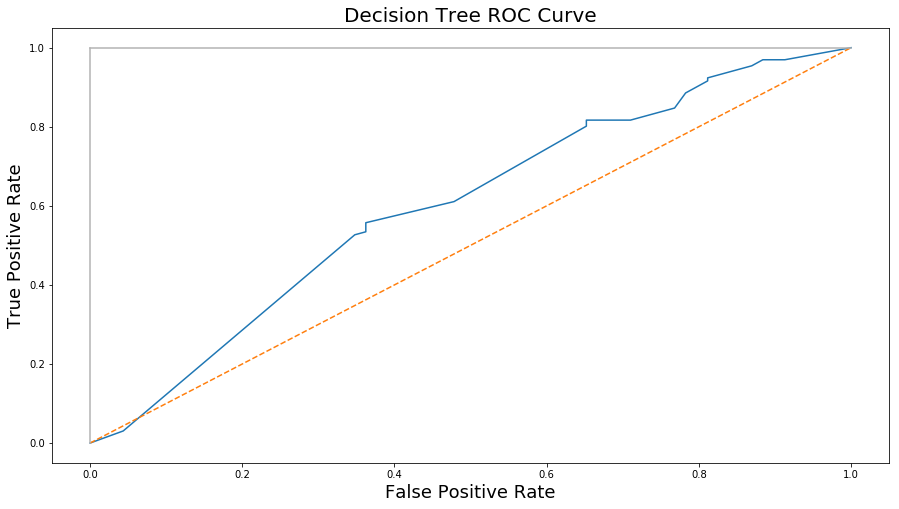

Area Under the Curve 0.600011063171


In [156]:
# Create true and false positive rates
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score_DT)

# Plot ROC curve
plt.figure(figsize=(15,8))
plt.title('Decision Tree ROC Curve', fontsize=20)
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate', fontsize=18)
plt.xlabel('False Positive Rate', fontsize=18)
plt.show()
print('Area Under the Curve',roc_auc_score(y_test, y_score_DT))

In [183]:
# Create adaboost-decision tree classifer object
adab_Classifier = AdaBoostClassifier(n_estimators=120,learning_rate=0.26,random_state=0)
# Train model
model_adab = adab_Classifier.fit(X_train, y_train.values.ravel())
y_adab = model_adab.predict(X_test)
y_score_adab = model_adab.predict_proba(X_test)[:,1]

In [184]:
get_metrics(y_adab, y_test)

Recall 0.774193548387
Precision 0.916030534351
Error_rate 0.23
Accuracy 0.77
F1 Score 0.839160839161


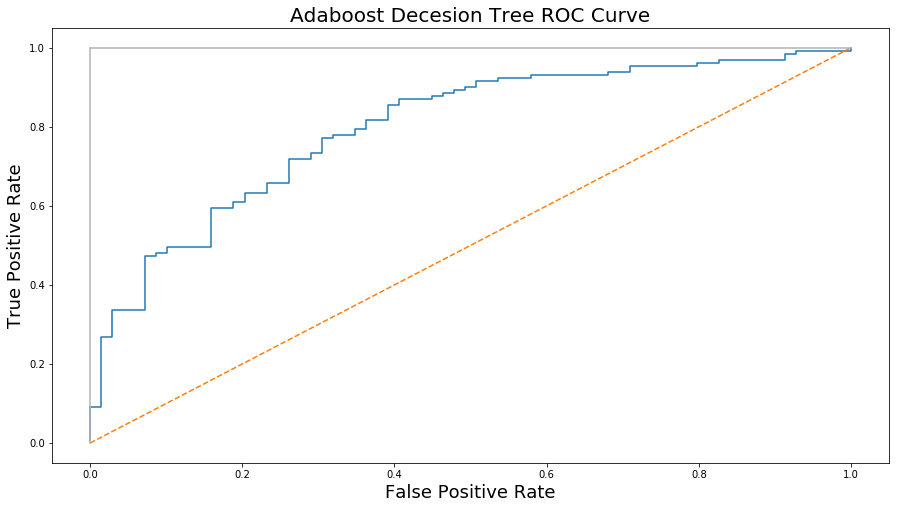

Area Under the Curve 0.797765239518


In [185]:
# Create true and false positive rates
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score_adab)

# Plot ROC curve
plt.figure(figsize=(15,8))
plt.title('Adaboost Decesion Tree ROC Curve', fontsize=20)
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate', fontsize=18)
plt.xlabel('False Positive Rate', fontsize=18)
plt.show()
print('Area Under the Curve',roc_auc_score(y_test, y_score_adab))

In [163]:
# Create a linear SVM classifier 
estimatorNum = np.arange(10, 200, 10)
error_rate =[]
for n in estimatorNum:
    adab_Classifier = AdaBoostClassifier(n_estimators=n,learning_rate=1,random_state=0)
    # Train the classifier
    model_adab = adab_Classifier.fit(X_train, y_train.values.ravel())
    temp = model_adab.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(temp,y_test).ravel()
    error_rate.append((fn+fp)/(tp+fn+fp+tn))

Text(0.5,1,'adaboost Error Rate using different number of estimators')

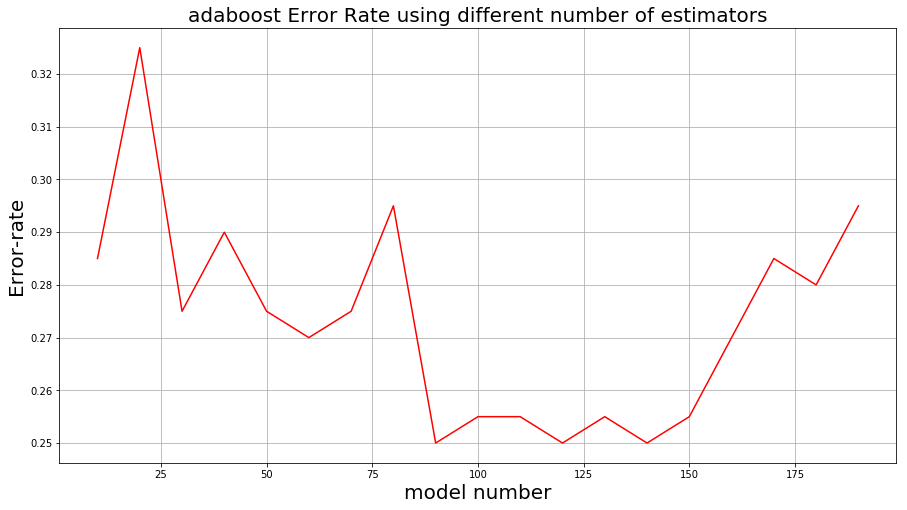

In [165]:
plt.subplots(figsize=(15,8))
plt.plot(estimatorNum,error_rate,color = 'red')
plt.grid(zorder=0)
plt.ylabel('Error-rate', fontsize=20)
plt.xlabel('model number', fontsize=20)
plt.title('adaboost Error Rate using different number of estimators', fontsize = 20)

In [169]:
# Create a linear SVM classifier 
learning_rate = np.arange(0.01, 1, 0.05)
error_rate =[]
for r in learning_rate:
    adab_Classifier = AdaBoostClassifier(n_estimators=120,learning_rate=r,random_state=0)
    # Train the classifier
    model_adab = adab_Classifier.fit(X_train, y_train.values.ravel())
    temp = model_adab.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(temp,y_test).ravel()
    error_rate.append((fn+fp)/(tp+fn+fp+tn))

Text(0.5,1,'adaboost Error Rate using different learning rate')

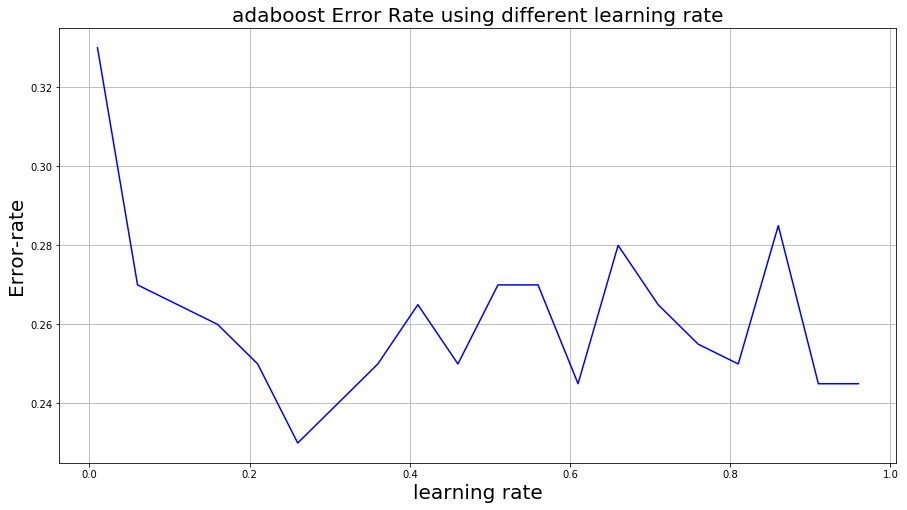

In [170]:
plt.subplots(figsize=(15,8))
plt.plot(learning_rate,error_rate,color = 'blue')
plt.grid(zorder=0)
plt.ylabel('Error-rate', fontsize=20)
plt.xlabel('learning rate', fontsize=20)
plt.title('adaboost Error Rate using different learning rate', fontsize = 20)